# SỬ DỤNG KIẾN TRÚC MẠNG UNET CHO BÀI TOÁN SEMANTIC SEGMENTATION

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
from skimage import io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import warnings
warnings.simplefilter("ignore")

#### LINK TỚI KAGGLE ĐỂ LẤY DATA

In [3]:
! pip install -q kaggle

In [4]:
! mkdir ~/.kaggle                 #make directory(folder) named .kaggle
 
! cp kaggle.json ~/.kaggle/       #add file to that folder
 
! chmod 600 ~/.kaggle/kaggle.json        #Change the permissions of the file.

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download oishee30/cocopersonsegmentation

print(os.listdir('/content'))
! mkdir data        #making directory data
 
! unzip cocopersonsegmentation.zip -d data            #unzipping data into data directory
os.remove('/content/cocopersonsegmentation.zip')

In [20]:
print(os.listdir('/content'))
os.listdir('/content/data')
path = '/content/data'

['.config', 'data', 'kaggle.json', 'sample_data']


In [21]:
xpath_coco = '/content/data/train2017_new/'
ypath_coco = '/content/data/train2017_ann/'
x_test_path = '/content/data/val2017_new/'
y_test_path = '/content/data/val2017_ann/'

input_img_paths_coco = sorted([os.path.join(xpath_coco, fname) for fname in os.listdir(xpath_coco)])
target_img_paths_coco = sorted([os.path.join(ypath_coco, fname) for fname in os.listdir(ypath_coco)])

print(len(input_img_paths_coco), len(target_img_paths_coco))
for input_path, target_path in zip(input_img_paths_coco[:4], target_img_paths_coco[:4]):
    print(input_path, "|", target_path)

64115 64115
/content/data/train2017_new/000000000036.jpg | /content/data/train2017_ann/000000000036.jpg
/content/data/train2017_new/000000000049.jpg | /content/data/train2017_ann/000000000049.jpg
/content/data/train2017_new/000000000061.jpg | /content/data/train2017_ann/000000000061.jpg
/content/data/train2017_new/000000000074.jpg | /content/data/train2017_ann/000000000074.jpg


In [5]:
! kaggle datasets download furkankati/person-segmentation-dataset

print(os.listdir('/content'))
! unzip person-segmentation-dataset.zip -d data
os.remove('/content/person-segmentation-dataset.zip')
print(os.listdir('/content'))
os.listdir('/content/data/')

100% 6.74G/6.74G [02:13<00:00, 38.2MB/s]
100% 6.74G/6.74G [02:13<00:00, 54.2MB/s]
['.config', 'kaggle.json', 'person-segmentation-dataset.zip', 'sample_data']


In [22]:
path = '/content/data/Training/'
for folder in os.listdir(path):
  if ('.txt' not in folder) and ('.hdf' not in folder) :
    print('No of images in',folder,len(os.listdir(path+folder)))

No of images in input 89832
No of images in Output 89832


In [23]:
xpath_89k = '/content/data/Training/input/'
ypath_89k = '/content/data/Training/Output/'
input_img_paths_89k = sorted([os.path.join(xpath_89k, fname) for fname in os.listdir(xpath_89k)])
target_img_paths_89k = sorted([os.path.join(ypath_89k, fname) for fname in os.listdir(ypath_89k)])

print(len(input_img_paths_89k), len(target_img_paths_89k))
for input_path, target_path in zip(input_img_paths_89k[:4], target_img_paths_89k[:4]):
    print(input_path, "|", target_path)

89832 89832
/content/data/Training/input/0_0000006.jpg | /content/data/Training/Output/0_0000006.png
/content/data/Training/input/0_0000007.jpg | /content/data/Training/Output/0_0000007.png
/content/data/Training/input/0_0000008.jpg | /content/data/Training/Output/0_0000008.png
/content/data/Training/input/0_0000010.jpg | /content/data/Training/Output/0_0000010.png


#### TRỘN 2 DATA LẠI



In [24]:
train_input_img_paths = input_img_paths_coco.copy()
target_input_img_paths = target_img_paths_coco.copy()

print(len(train_input_img_paths), len(target_input_img_paths))

64115 64115


In [25]:
for img in input_img_paths_89k:
  train_input_img_paths.append(img)
 
for img in target_img_paths_89k:
  target_input_img_paths.append(img)

print(len(train_input_img_paths), len(target_input_img_paths))

153947 153947


In [26]:
train_input_img_paths = sorted(train_input_img_paths)    #sorting
train_target_img_paths = sorted(target_input_img_paths)   #sorting
 
val_input_img_paths = sorted([os.path.join(x_test_path, fname) for fname in os.listdir(x_test_path)])
val_target_img_paths = sorted([os.path.join(y_test_path, fname) for fname in os.listdir(y_test_path)])
 
print("Number of training samples:", len(train_input_img_paths))
print("Number of validation samples:", len(val_input_img_paths))
 
for input_path, target_path in zip(train_input_img_paths[:4], train_target_img_paths[:4]):
    print(input_path, "|", target_path)

Number of training samples: 153947
Number of validation samples: 2693
/content/data/Training/input/0_0000006.jpg | /content/data/Training/Output/0_0000006.png
/content/data/Training/input/0_0000007.jpg | /content/data/Training/Output/0_0000007.png
/content/data/Training/input/0_0000008.jpg | /content/data/Training/Output/0_0000008.png
/content/data/Training/input/0_0000010.jpg | /content/data/Training/Output/0_0000010.png


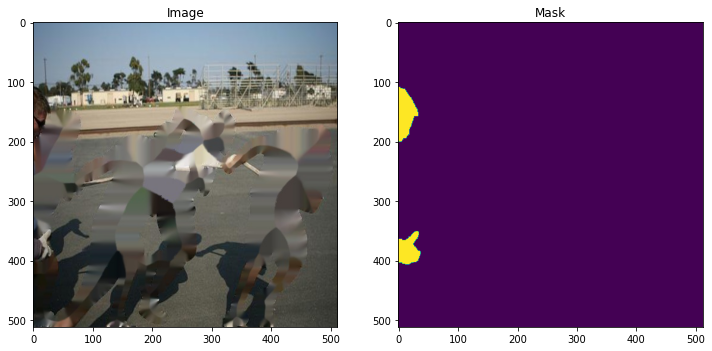

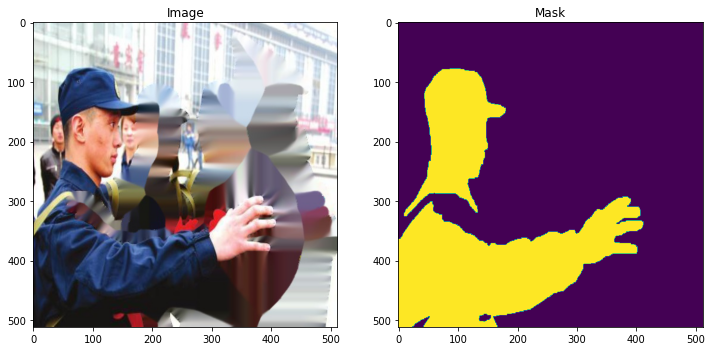

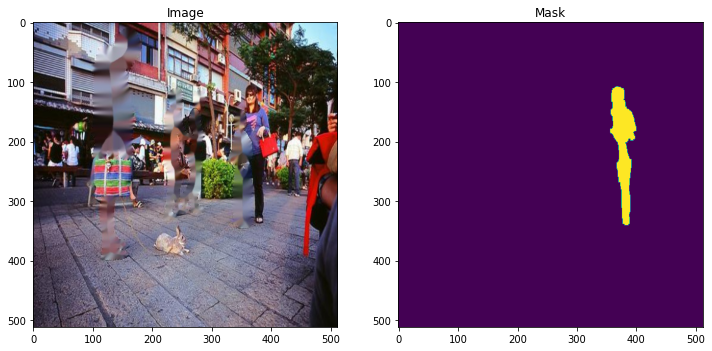

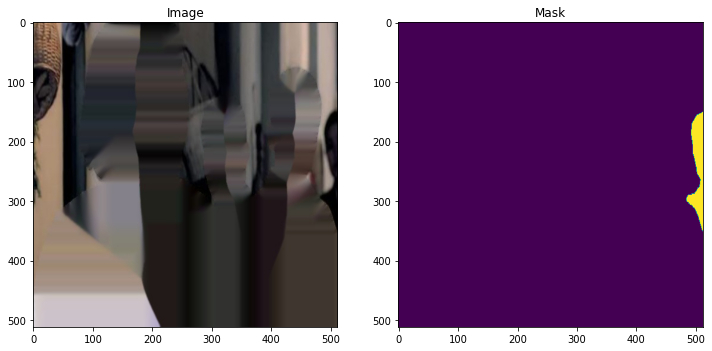

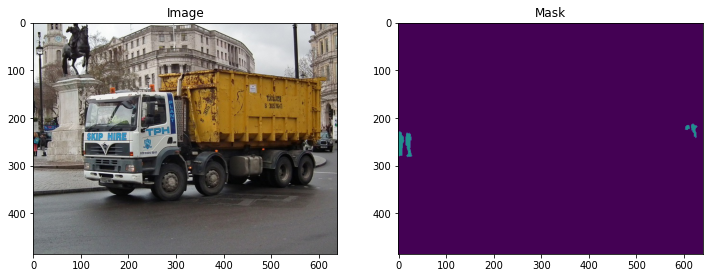

In [27]:
n_images = 5
for i in np.random.randint(0,len(train_input_img_paths),n_images):
 
  fig = plt.figure(figsize=(12,6))
  fig.tight_layout()
 
  plt.subplot(1,2,1)
  img = plt.imread(train_input_img_paths[i])
  plt.imshow(img)
  plt.title('Image')
 
  plt.subplot(1,2,2)
  img = plt.imread(train_target_img_paths[i])
  plt.imshow(img)
  plt.title('Mask')
 
  plt.show()
  print()

(array([0, 1, 2], dtype=uint8), array([260770,  12504,      6]))
(427, 640)


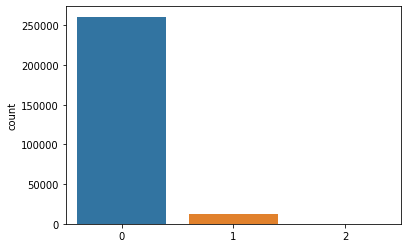

In [28]:
mask = plt.imread(train_target_img_paths[-1])
print(np.unique(mask, return_counts= True))
print(mask.shape)
sns.countplot(mask.ravel())
plt.show()

In [29]:
batch_size = 32
img_size = (256,256)

class Data_Gen(keras.utils.Sequence):
    """Helper function to iterate over the data (as Numpy arrays)."""
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
 
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size                    # 64115//32
 
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size                                                            # 0
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]                # [0: 0+32]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
 
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")           #(32,256,256,3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = np.array(img)/255
            x[j] = img
 
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")             #(32,256,256,1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")        #(256,256)
            img = np.array(img)
            img[img!=0] = 1
            y[j] = np.expand_dims(img, 2)                                                  #(256,256,1)
 
        return x, y

In [30]:
# checking gererator function
train_gen = Data_Gen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = Data_Gen(batch_size, img_size, val_input_img_paths, val_target_img_paths)
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 1)


In [31]:
print(y[0].shape)
print(np.unique(y[0], return_counts= True))

(256, 256, 1)
(array([0, 1], dtype=uint8), array([61859,  3677]))


# Model Building

In [48]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [52]:
input_size = (256,256,3)
inputs = Input(input_size)

#Encoder
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)


#Decoder
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs, conv10)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_134 (Conv2D)            (None, 256, 256, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_135 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_134[0][0]']             
                                )                                                           

In [55]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
 
model.compile(optimizer=opt, loss="binary_crossentropy", 
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])    #metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
 
filepath = "/content/drive/MyDrive/Colab_Notebooks/Background_remover/Deep_Model/model_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 1
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', start - end)

In [ ]:
history = model_history.history 

In [ ]:
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_iou = history['mean_io_u']
val_iou = history['val_mean_io_u']

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yticks(np.arange(0, .5,.05))
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0,1.1,.1))
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_iou, 'r', label='Training mean_io_u')
plt.plot(val_iou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u')
plt.yticks(np.arange(0,1,.05))
plt.legend()
plt.show()

# Testing

In [59]:
def ploting(imgpath, maskpath):
  plt.figure(figsize=(12,4))

  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)/255

  plt.subplot(1,3,1)
  plt.title('Original')
  plt.imshow(im)

  im = im.reshape((1,)+im.shape)
  im.shape

  pred = model.predict(im)
  
  p = pred.copy()
  p = p.reshape(p.shape[1:-1])

  p[np.where(p>.2)] = 1
  p[np.where(p<.2)] = 0

  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)

  im[:,:,0] = im[:,:,0]*p 
  im[:,:,0][np.where(p!=1)] = 255
  im[:,:,1] = im[:,:,1]*p 
  im[:,:,1][np.where(p!=1)] = 255
  im[:,:,2] = im[:,:,2]*p
  im[:,:,2][np.where(p!=1)] = 255

  plt.subplot(1,3,2)
  plt.imshow(im)
  
  if maskpath:
    plt.subplot(1,3,3)
    mask = io.imread(maskpath)
    plt.imshow(mask)

    plt.show()

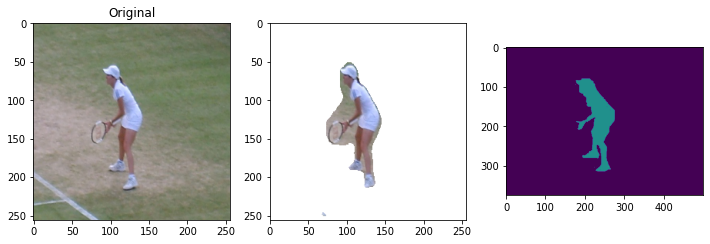

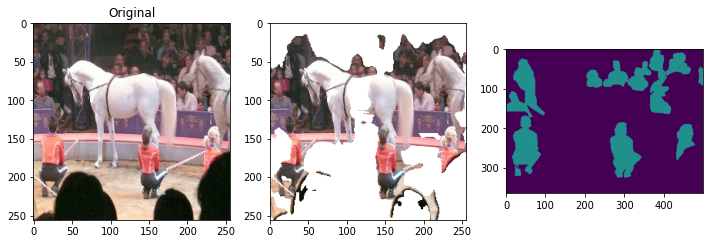

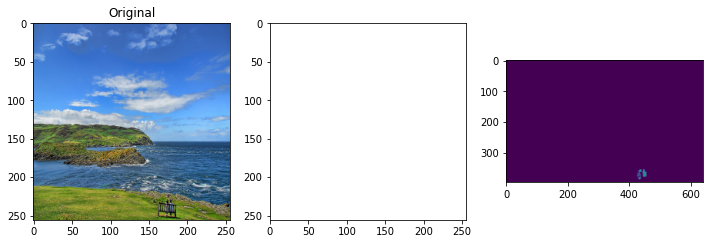

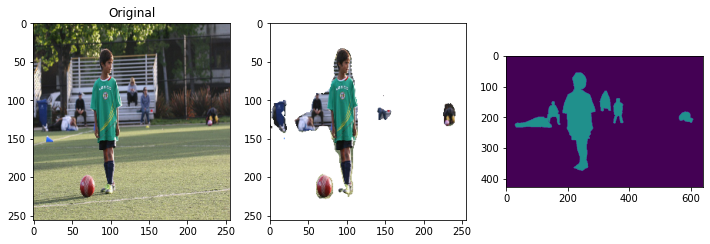

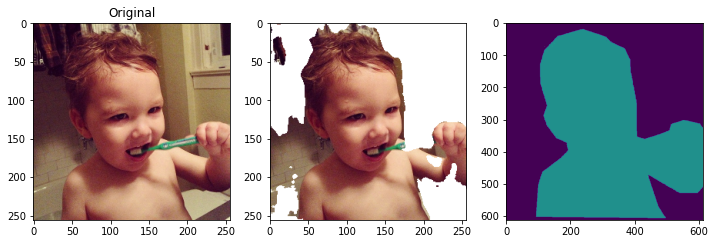

In [60]:
n_images = 5
for i in np.random.randint(0,len(val_input_img_paths),n_images):
  ploting(val_input_img_paths[i], val_target_img_paths[i])

# The End